# Neuro-symbolic integration report

Instructor: Prof. Jędrzej Potoniec

Authors:
- Kacper Dobek 148247
- Daniel Jankowski 148257

### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

from h5py import File

sns.set(style="whitegrid", font_scale=1.3)

%matplotlib inline

In [2]:
plot_dir = Path("plots")
plot_dir.mkdir(exist_ok=True)

### Part 1: Spike detection EDA

The first part of the report is dedicated to the exploratory data analysis of the rise in firing rate. The goal is to analyze the data and visualize it in a way that helps us understand the nature of rising firing rate.

Our initial assumption is that the rise in firing rate is a result of a change in the input signal with some delay. We will analyze the data to confirm or refute this assumption.

In [3]:
def read_h5_to_numpy(
    file_path: str, subset_type: str, response_type: str
):
        """
        Reads data from an HDF5 file and converts it to numpy arrays. Normalizes the output data if the scaler is provided.
        Returns:
            Tuple[ndarray[Any, dtype[Any]], ndarray[Any, dtype[Any]]]: A tuple containing the input data (X) and the output data (y).
        """  # noqa: E501
        with File(file_path, "r") as h5file:
            # Read as numpy arrays
            X = np.asarray(h5file[subset_type]["stimulus"])
            y = np.asarray(
                h5file[subset_type]["response"][response_type]
            )
        X = X.astype("float32") / 255.0
        y = y.astype("float32")

        return X, y

In [4]:
x, y = read_h5_to_numpy("../data/neural_code_data/naturalscene.h5", 'train', 'firing_rate_10ms')

Let's show a few examples of input frames

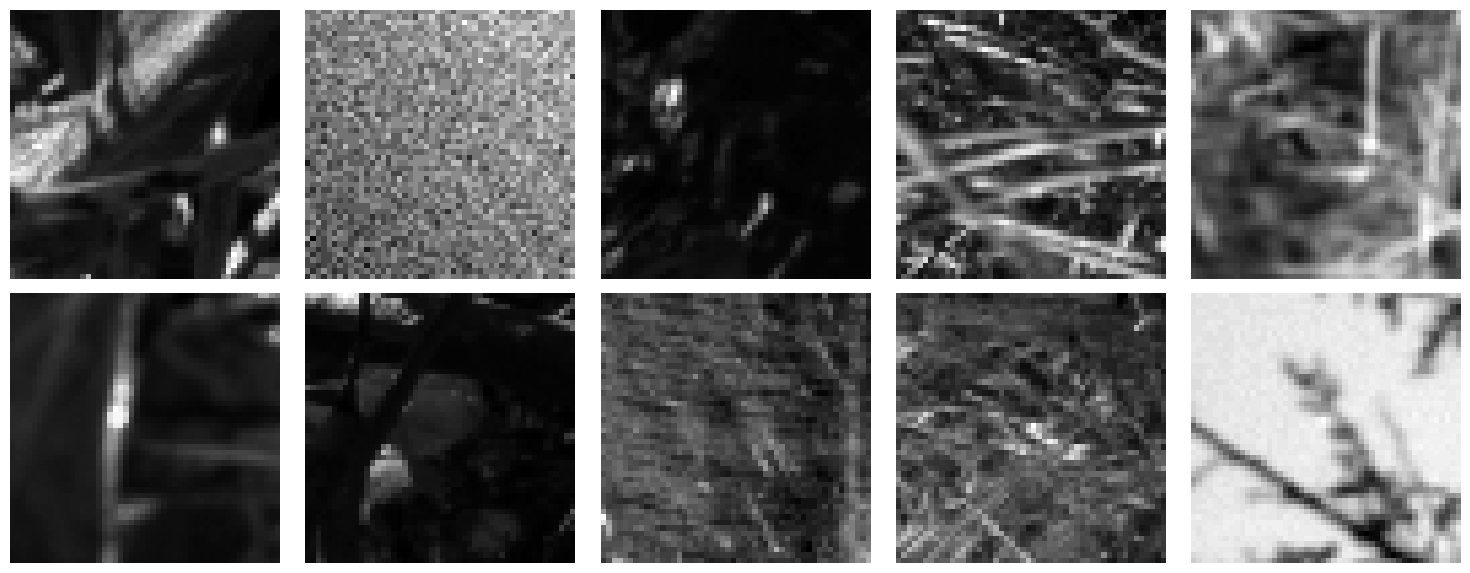

In [ ]:
np.random.seed(42)
random_indices = np.random.choice(x.shape[0], 10, replace=False)
x_sample = x[random_indices]
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(x_sample[i], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

The function below plots the last N images when a rising firing rate  is detected and along with response values below them.


In [ ]:
def plot_spike_images(responses: np.ndarray, images: np.ndarray, N: int = 5, save=False):
    """
    Plots the last N images when a rising firing rate (response > 0) is detected and also plots the responses below them.
    
    Parameters:
    - responses: 1D numpy array of neural responses.
    - images: 3D numpy array of shape (num_samples, 50, 50) containing grayscale images.
    - N: Number of images to plot before the detected spike.
    """
    spike_indices = np.where(responses > 0)[0]  # Indices where response > 0
    
    if len(spike_indices) == 0:
        print("No spikes detected.")
        return
    
    for spike_idx in spike_indices:
        start_idx = max(0, spike_idx - N)  # Ensure valid index range
        selected_indices = np.arange(start_idx, spike_idx + 1)
        selected_responses = responses[selected_indices]
        
        fig = plt.figure(figsize=(12, 4))
        gs = fig.add_gridspec(2, spike_idx - start_idx + 1, height_ratios=[3, 1])
        # fig.suptitle(f"Spike detected: {responses[spike_idx]:.2f} at index {spike_idx}")
        
        for i, idx in enumerate(selected_indices):
            ax = fig.add_subplot(gs[0, i])
            ax.imshow(images[idx], cmap='gray')
            ax.axis('off')
            ax.set_title(str(idx))
        
        ax_response = fig.add_subplot(gs[1, :])
        ax_response.plot(selected_indices, selected_responses, marker='o', linestyle='-', color='b')
        ax_response.set_title("RGC Responses")
        ax_response.set_xlabel("Time step")
        ax_response.set_ylabel("Firing rate [Hz]")
        
        plt.tight_layout()
        plt.show()
        if save:
            fig.savefig(f"plots/spike_images_{spike_idx}.pdf")

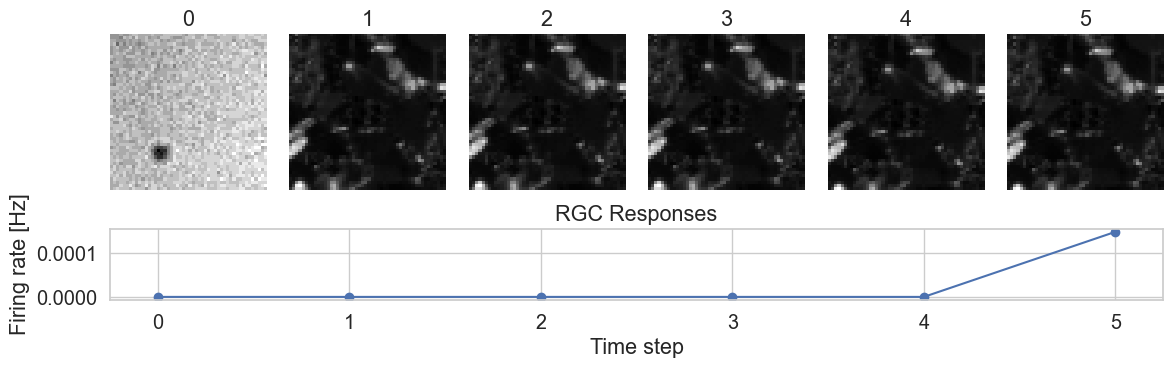

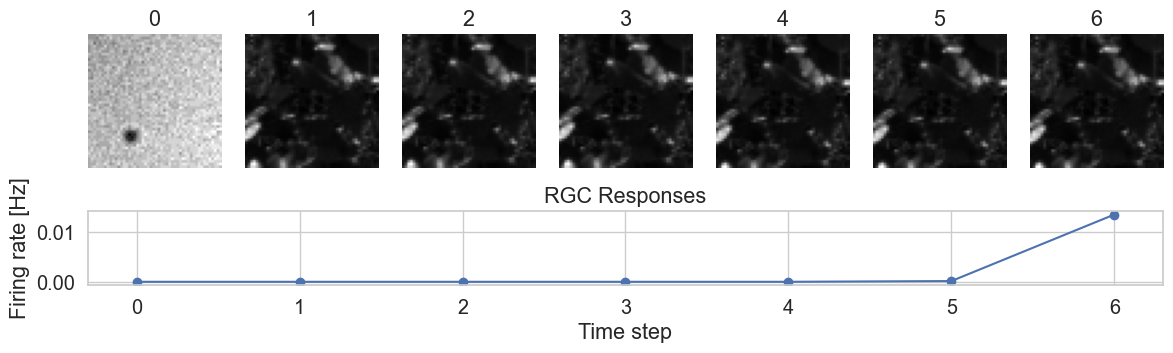

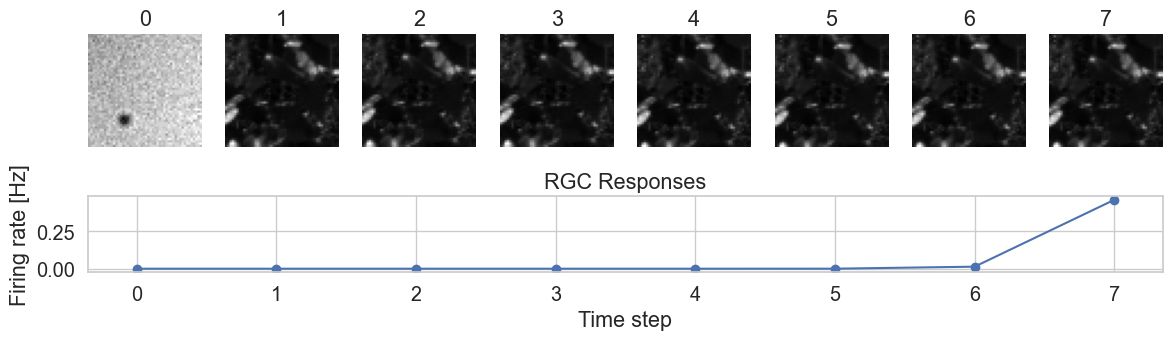

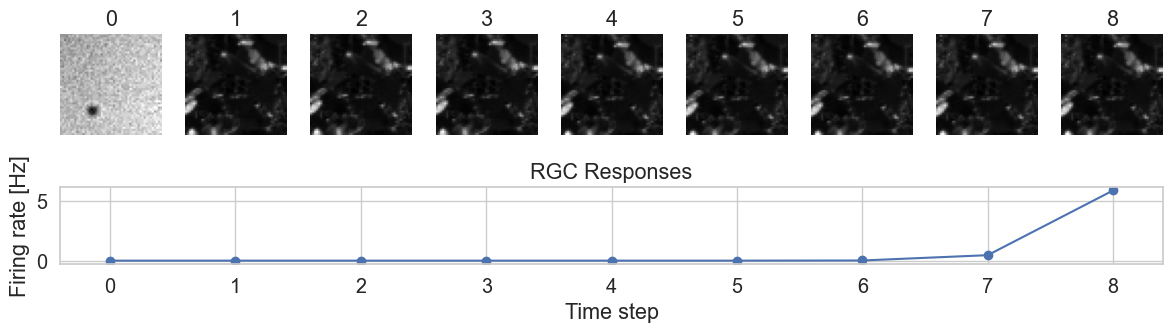

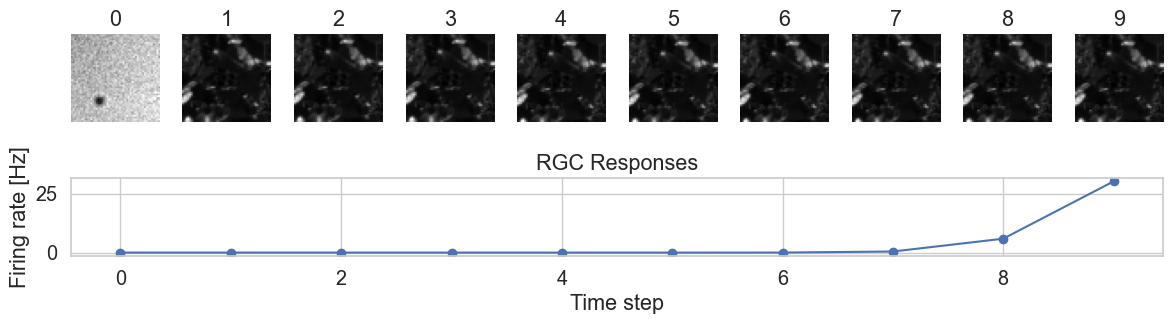

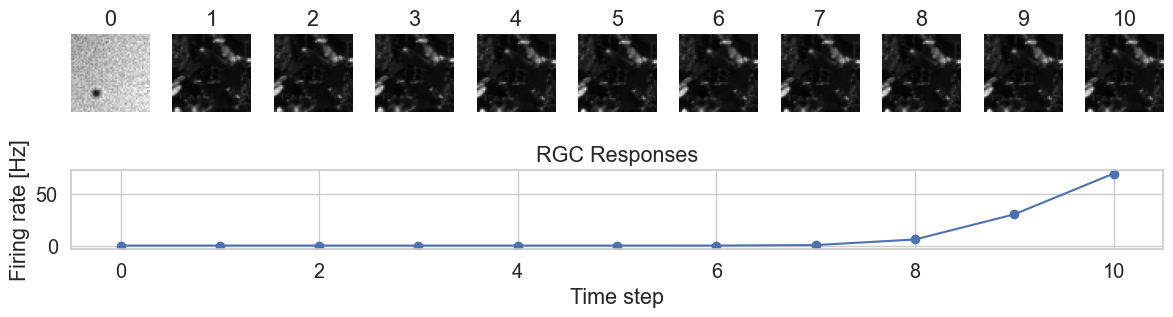

In [ ]:
y_0 = y[0] # Select the first channel

plot_spike_images(y_0[809:820], x[809:820], N=10, save=False)

### Part 2: Approximation of CfC dynamics using Sindy

We attach the `extract_equation.py` script to the submission. The script was used to extract the equation of the system using the SINDy Python package.

This code implements a pipeline for extracting and analyzing interpretable dynamical equations from the hidden states of a deep neural network, specifically a PyTorch model composed of a convolutional encoder and a CfC (Closed-form Continuous-time) component. The main goal is to use the SINDy (Sparse Identification of Nonlinear Dynamics) framework to approximate the evolution of the model’s hidden states with explicit, human-readable differential equations.

The workflow begins by loading a trained neural network and dataset, then pruning the model to reduce its complexity. The code collects hidden state trajectories from the CfC component as the model processes the training data. These trajectories are used to fit a SINDy model, which identifies a sparse set of nonlinear differential equations that best describe the hidden state dynamics. The identified equations are saved for further analysis.

The code also provides tools for simulating the hidden state evolution using the learned SINDy equations, starting from an initial state derived from the encoder. The simulation results can be visualized and compared to the original neural network’s predictions. Evaluation functions compute metrics such as mean squared error and Pearson correlation between the SINDy-predicted states, the neural network’s outputs, and the ground truth targets.

Overall, this script bridges deep learning and symbolic regression, enabling the extraction of interpretable dynamical models from complex neural architectures. It supports model pruning, batch processing, parallel evaluation, and comprehensive logging, making it a robust tool for analyzing the internal dynamics of continuous-time neural networks.

```
(h0)' = 0.534 1 + 10.377 h0 + 13.713 h1 + -24.688 h2 + -5.088 h3 + 15.654 h4 + -14.791 h5 + 23.970 h6 + -23.659 h7 + 24.527 h8 + -107.420 h0^2 + -102.237 h0 h1 + 504.749 h0 h2 + -51.477 h0 h3 + 122.794 h0 h4 + -96.619 h0 h5 + -4.978 h0 h6 + -89.888 h0 h7 + -212.798 h0 h8 + -1571.400 h1^2 + 1292.621 h1 h2 + 194.513 h1 h3 + 364.650 h1 h4 + -204.997 h1 h5 + 102.619 h1 h6 + 1472.792 h1 h7 + 3387.343 h1 h8 + -1111.397 h2^2 + -53.275 h2 h3 + -133.208 h2 h4 + 510.764 h2 h5 + 477.261 h2 h6 + -357.330 h2 h7 + -597.828 h2 h8 + 37.741 h3^2 + -142.205 h3 h4 + -11.095 h3 h5 + -216.188 h3 h6 + -73.328 h3 h7 + -533.328 h3 h8 + 90.157 h4^2 + -93.648 h4 h5 + 245.726 h4 h6 + -287.923 h4 h7 + 109.456 h4 h8 + 69.291 h5^2 + -38.328 h5 h6 + -39.898 h5 h7 + 378.854 h5 h8 + 94.725 h6^2 + -141.611 h6 h7 + 225.512 h6 h8 + -208.231 h7^2 + 48.876 h7 h8 + 30.757 h8^2 + -121.549 h0^3 + 1833.684 h0^2 h1 + 606.277 h0^2 h2 + -204.520 h0^2 h3 + -966.325 h0^2 h4 + 69.220 h0^2 h5 + -1239.522 h0^2 h6 + -13.777 h0^2 h7 + -1306.480 h0^2 h8 + -5743.414 h0 h1^2 + -3870.399 h0 h1 h2 + 3713.875 h0 h1 h3 + -527.637 h0 h1 h4 + 145.666 h0 h1 h5 + 3429.980 h0 h1 h6 + 3740.344 h0 h1 h7 + 8803.036 h0 h1 h8 + -1294.063 h0 h2^2 + -1217.918 h0 h2 h3 + 4715.536 h0 h2 h4 + 1497.172 h0 h2 h5 + 5749.602 h0 h2 h6 + -623.769 h0 h2 h7 + 6614.306 h0 h2 h8 + 19.499 h0 h3^2 + -616.337 h0 h3 h4 + 313.868 h0 h3 h5 + -1337.583 h0 h3 h6 + -852.023 h0 h3 h7 + -3389.707 h0 h3 h8 + 545.026 h0 h4^2 + -514.091 h0 h4 h5 + 812.314 h0 h4 h6 + -962.669 h0 h4 h7 + 289.901 h0 h4 h8 + 33.230 h0 h5^2 + -14.329 h0 h5 h6 + -170.486 h0 h5 h7 + 454.253 h0 h5 h8 + 360.520 h0 h6^2 + -1485.576 h0 h6 h7 + 2593.290 h0 h6 h8 + -338.053 h0 h7^2 + -1433.292 h0 h7 h8 + 6771.100 h0 h8^2 + 15111.141 h1^3 + 18807.164 h1^2 h2 + -3148.564 h1^2 h3 + -13978.811 h1^2 h4 + -4717.872 h1^2 h5 + -22936.164 h1^2 h6 + -4289.414 h1^2 h7 + -42459.758 h1^2 h8 + -10636.998 h1 h2^2 + -1196.713 h1 h2 h3 + -752.727 h1 h2 h4 + 9830.820 h1 h2 h5 + -5501.971 h1 h2 h6 + -8853.610 h1 h2 h7 + -39207.492 h1 h2 h8 + -1312.913 h1 h3^2 + 2756.687 h1 h3 h4 + 1408.110 h1 h3 h5 + 5164.589 h1 h3 h6 + -4.442 h1 h3 h7 + 16534.850 h1 h3 h8 + 2293.476 h1 h4^2 + -1362.836 h1 h4 h5 + 2296.949 h1 h4 h6 + 10620.373 h1 h4 h7 + 12017.040 h1 h4 h8 + -2317.449 h1 h5^2 + -3472.120 h1 h5 h6 + -932.895 h1 h5 h7 + 115.146 h1 h5 h8 + -1485.884 h1 h6^2 + 13482.284 h1 h6 h7 + -1440.980 h1 h6 h8 + -1471.188 h1 h7^2 + 15148.195 h1 h7 h8 + -49971.086 h1 h8^2 + 4388.114 h2^3 + 752.592 h2^2 h3 + -3764.700 h2^2 h4 + -8714.616 h2^2 h5 + -5782.956 h2^2 h6 + 535.907 h2^2 h7 + 8960.903 h2^2 h8 + -66.942 h2 h3^2 + 853.181 h2 h3 h4 + -1186.433 h2 h3 h5 + 3094.247 h2 h3 h6 + 932.541 h2 h3 h7 + 7439.275 h2 h3 h8 + -680.857 h2 h4^2 + 1463.542 h2 h4 h5 + 491.968 h2 h4 h6 + 477.755 h2 h4 h7 + -3711.868 h2 h4 h8 + 1176.946 h2 h5^2 + 1288.895 h2 h5 h6 + 654.283 h2 h5 h7 + -7210.557 h2 h5 h8 + 1128.432 h2 h6^2 + 2439.257 h2 h6 h7 + -8914.517 h2 h6 h8 + 1423.539 h2 h7^2 + 6102.950 h2 h7 h8 + 1808.321 h2 h8^2 + 97.006 h3^3 + 116.993 h3^2 h4 + -24.957 h3^2 h5 + -227.803 h3^2 h6 + 356.810 h3^2 h7 + -1863.301 h3^2 h8 + -771.572 h3 h4^2 + -56.268 h3 h4 h5 + -1627.748 h3 h4 h6 + -979.536 h3 h4 h7 + -1532.225 h3 h4 h8 + 190.431 h3 h5^2 + 525.477 h3 h5 h6 + -158.533 h3 h5 h7 + 53.461 h3 h5 h8 + -585.906 h3 h6^2 + -1501.524 h3 h6 h7 + 1628.434 h3 h6 h8 + 201.707 h3 h7^2 + -3795.491 h3 h7 h8 + 10483.943 h3 h8^2 + 145.686 h4^3 + 205.228 h4^2 h5 + 627.173 h4^2 h6 + -1188.145 h4^2 h7 + 122.490 h4^2 h8 + 62.928 h4 h5^2 + 864.804 h4 h5 h6 + 328.773 h4 h5 h7 + 2673.697 h4 h5 h8 + 663.552 h4 h6^2 + -1798.931 h4 h6 h7 + 1118.008 h4 h6 h8 + -1432.640 h4 h7^2 + -306.694 h4 h7 h8 + -794.410 h4 h8^2 + 55.647 h5^3 + -560.710 h5^2 h6 + 844.252 h5^2 h7 + -1741.266 h5^2 h8 + 544.898 h5 h6^2 + 581.506 h5 h6 h7 + 469.582 h5 h6 h8 + 255.944 h5 h7^2 + 1335.999 h5 h7 h8 + -2620.509 h5 h8^2 + 249.998 h6^3 + -372.204 h6^2 h7 + 795.299 h6^2 h8 + -1899.068 h6 h7^2 + 1081.207 h6 h7 h8 + -2238.253 h6 h8^2 + 133.637 h7^3 + -915.008 h7^2 h8 + 3398.197 h7 h8^2 + -6991.128 h8^3
```

In [13]:
pred_dir = Path("../sindy/compare_models")
pred_files = pred_dir.glob("*.csv")

# Create a dictionary to store the dataframes
pred_dict = {}

for pred_file in pred_files:
    # Read the csv file
    df = pd.read_csv(pred_file)
    # Get the model name
    model_name = pred_file.stem
    # Store the dataframe in the dictionary
    pred_dict[model_name] = df

print(pred_dict.keys())

dict_keys(['CfC', 'CfC-pruned', 'Sindy-pruned', 'Sindy', 'Target'])


In [14]:
pred_dict["Target"].head()

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.201739,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.121669,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.026943,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.002191,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000065,0.0,0.0,0.0,0.0,0.0


In [15]:
custom_colors = sns.color_palette("tab10")

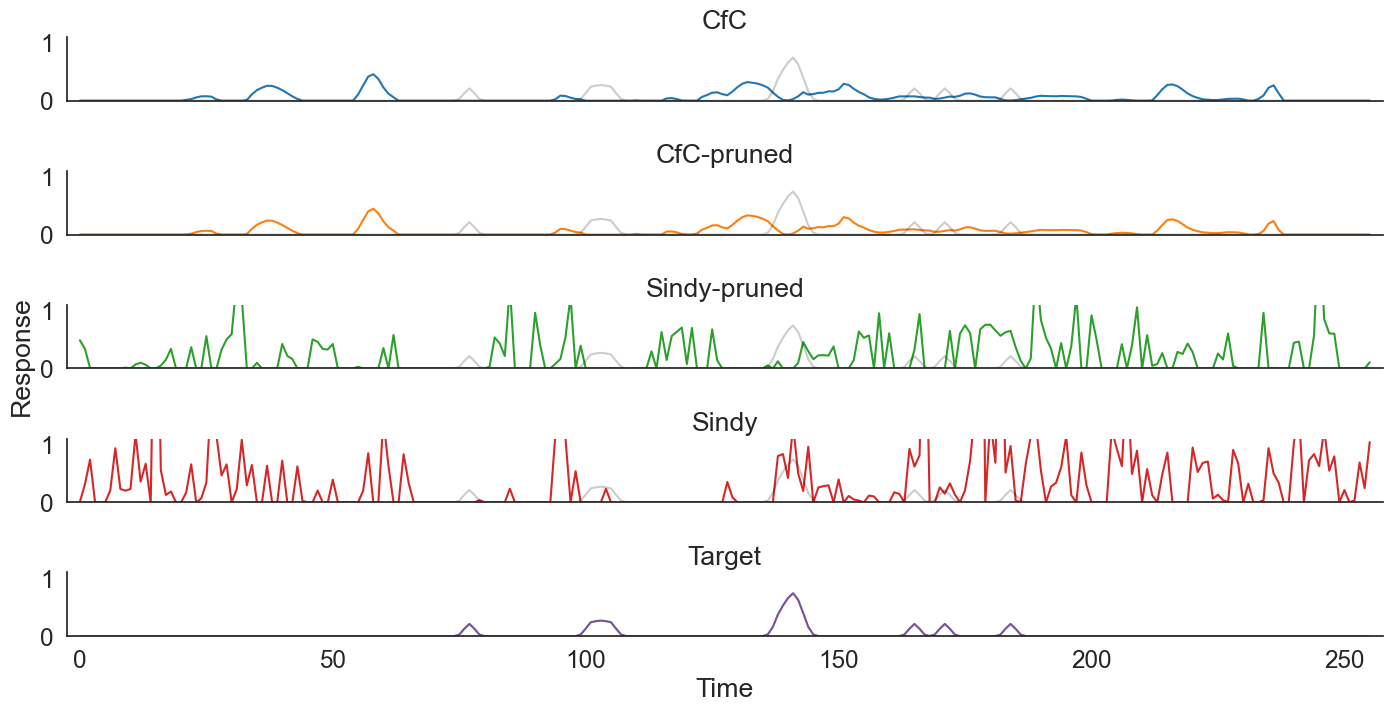

In [ ]:
# Set the style
sns.set_context("paper")
# Set font_scale according to needs
sns.set(style="white", font_scale=1.6)

# Create a figure and axis
n_subplots = len(pred_dict)
fig, axes = plt.subplots(
    n_subplots,
    1,
    figsize=(
        14,
        1.5 * n_subplots,
    ),
    sharey=True,
)

# Select output channel
output_channel = "0"

# Iterate over the dictionary
for i, (model_name, df) in enumerate(pred_dict.items()):
    # Create a scatter plot
    x_axis_values = df[output_channel].index
    sns.lineplot(
        x=x_axis_values, y=output_channel, data=df, ax=axes[i], color=custom_colors[i]
    )
    # Plot the target values in background
    # Adjust data frame length
    target_df = pred_dict["Target"].iloc[: len(df)]
    sns.lineplot(
        x=target_df.index,
        y=output_channel,
        data=target_df,
        ax=axes[i],
        color="black",
        alpha=0.2,
    )
    # Add a title
    axes[i].set_title(model_name)
    axes[i].get_xaxis().set_visible(False)
    axes[i].set_ylabel("")
    axes[i].margins(x=0.01)
    axes[i].set_ylim(0, 1.1)

# Set x axis label for the last subplot
axes[-1].get_xaxis().set_visible(True)
axes[-1].set_xlabel("Time")

# Set y axis label for the figure
fig.text(-0.001, 0.5, "Response", va="center", rotation="vertical")

# Set fig title
# fig.suptitle(f"Predictions for output channel {output_channel}", fontsize=18)

sns.despine()
# Adjust the layout
plt.tight_layout()
plt.show()

In [17]:
# Calculate mae for each model
mae_dict = {}
for model_name, df in pred_dict.items():
    if model_name == "Target":
        continue
    # Calculate the mean absolute error
    mae = np.mean(np.abs(df - pred_dict["Target"]))
    mae_dict[model_name] = mae

# Create a DataFrame from the mae_dict
mae_df = pd.DataFrame.from_dict(mae_dict, orient="index", columns=["MAE"])
# Sort the DataFrame by MAE
mae_df = mae_df.sort_values(by="MAE", ascending=True)

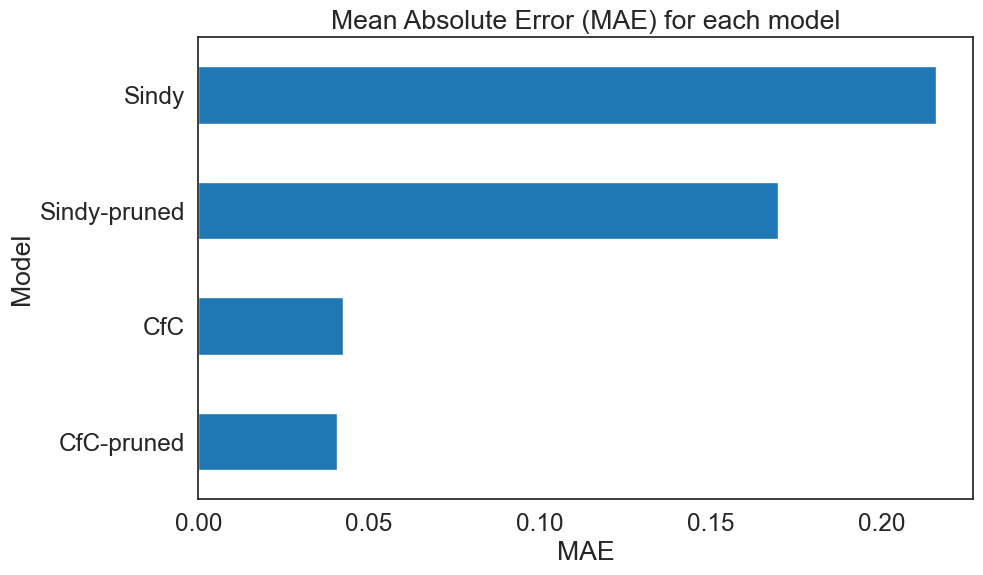

In [20]:
mae_df.plot(
    kind="barh",
    figsize=(10, 6),
    color=custom_colors[: len(mae_df)],
    legend=False,
    title="Mean Absolute Error (MAE) for each model",
    xlabel="MAE",
    ylabel="Model",
)
plt.show()